In [5]:
import torch
print("Using torch", torch.__version__)
import numpy as np
import os
import time
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.autograd import grad
import torch.utils.data as data

import matplotlib.pyplot as plt

%matplotlib inline

Using torch 2.1.1+cu121


## Linear advection equation: Finite-differences vs. Physics-Informed Neural Networks (PINNs)

Here we will show how PINNs can be used to solve the linear advection equation, and compare the results of this method with the traditional finite differences scheme we explored in previous weeks. In particular, we will compare PINNs against the FTCS method.

Recall the linear advection equation:
$\frac{\partial f}{\partial t} = -c \frac{\partial f}{\partial x}$.

### Forward-in-teim Centered-in-space (FTCS) method

The FTCS method consists of the following algorithm:

$f_j^{n+1} = f_j^{n} - c\frac{\Delta t}{2\Delta x} (f_{j+1}^{n}-f_{j-1}^{n})$ for $j = 1, 2, ..., M-2$

Imposing periodic boundary conditions in space $(f(x) = f(x+L))$ is implemented as:

$f_0^{n+1} = f_0^{n} - c\frac{\Delta t}{2\Delta x} (f_{1}^{n}-f_{M-1}^{n})$ for left boundary ($j=0$)

$f_{M-1}^{n+1} = f_{M-1}^{n} - c\frac{\Delta t}{2\Delta x} (f_{0}^{n}-f_{M-2}^{n})$ for right boundary ($j=M-1$)

This algorithm is implemented in the routine below.

In [11]:
def FTCS_advection(f_np1, f_n, dx, dt):
    """
    This routine uses the FTCS method to calculate f_np1 (f at time n+1) given f_n (f at time n) 
    and spatial and temporal steps dx and dt.
    This method assumed periodic boundary conditions.
    The advection speed is set to c=1. 
    We assume here that space is measured in units of meters and time in seconds => c is in units of m/s).
    """
    
    c = 1
    M = len(f_np1)
    
    # update interior points
    for j in range(1, M-1):
        f_np1[j] = f_n[j] - c*dt/(2*dx) * (f_n[j+1]-f_n[j-1])

    # update boundary points assuming periodic boundary conditions
    f_np1[0] = f_n[0] - c*dt/(2*dx) * (f_n[1]-f_n[M-1])
    f_np1[M-1] = f_n[M-1] - c*dt/(2*dx) * (f_n[0]-f_n[M-2])

Here we initialize the physical parameters of our domain (the size of our domain in space, $L$, and the time we want to integrate/simulate, $T$). We also configure the numerical parameters for our method (the spatial step size, $\Delta x$, and the time step, $\Delta t$).

In [12]:
L = 8 # physical size of the domain (in m)
M = 128 # number of spatial grid points

dx = L/M # spatial step size

x = np.arange(M)*dx # x-coordinates of grid points

# initializing f_n and f_np1 arrays and setting them to zero
f_n = np.zeros(M)
f_np1 = np.zeros(M)

Here we complete our initialization by setting the initial condition for our system. In this case, we will initialize a gaussian pulse, and want to observe its advection by the linear advection equation.

Text(0, 0.5, '$f(x,t=0)$')

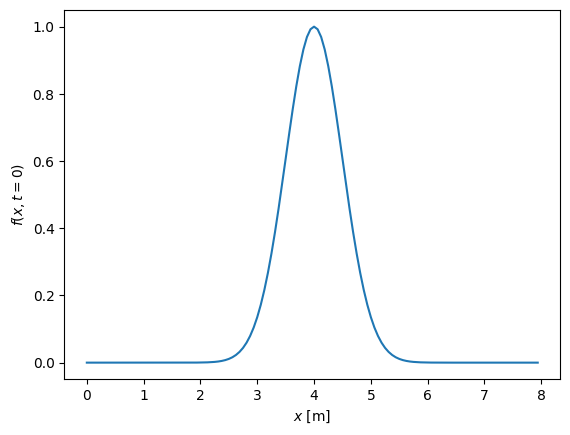

In [13]:
def gaussian_IC(x, x0, sigma):
    """
    Gaussian initial condition.
    """
    return np.exp(-(x-x0)**2 / (2*sigma**2))

f_0 = gaussian_IC(x=x, x0=4, sigma=0.5)

plt.plot(x, f_0)
plt.xlabel('$x$ [m]')
plt.ylabel('$f(x,t=0)$')

The following code integrates the linear advection equation using the FTCS method:

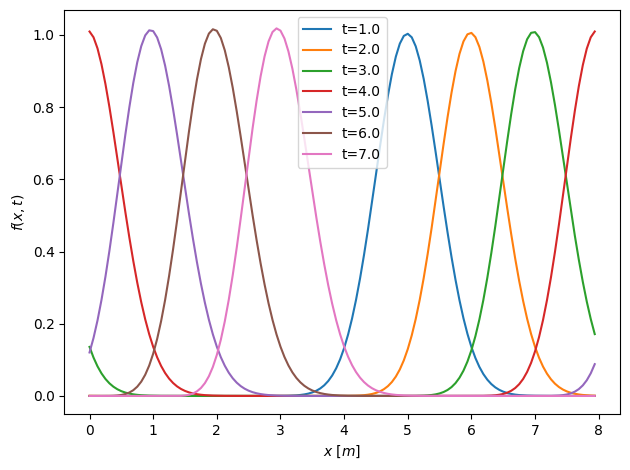

In [14]:
T = 8 # Physical time to simulate (in units of seconds)
dt = 0.025 * dx # Time step in units of seconds.

N = int(T/dt) # Total number of timesteps needed to reach t=T.

t = np.arange(N+1)*dt
f_n[:] = f_0

ndump = int(1/dt)

f_evol = np.zeros((N, M))
f_evol[0,:] = f_0

for n in range(1, N):
    FTCS_advection(f_np1, f_n, dx, dt) # advance one time step
    f_n[:] = f_np1 # copy f_np1 into f_n for next time step
    
    f_evol[n,:] = f_np1
    
    # if n is a multiple of ndump frequency, then plot
    if n%ndump ==0:
        plt.plot(x, f_n, label = 't='+str(round(n*dt,1)))

plt.xlabel('$x$ $[m]$')
plt.ylabel('$f(x,t)$')
plt.legend()
plt.tight_layout()

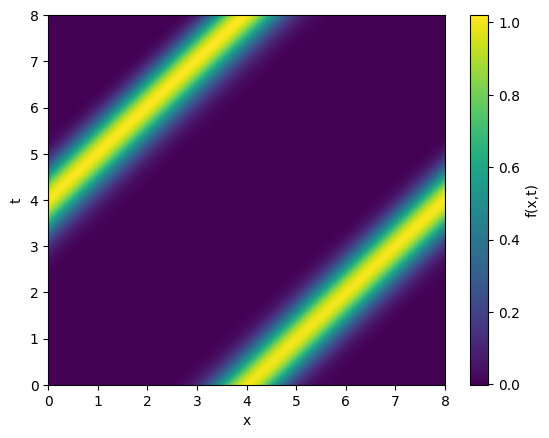

In [15]:
plt.imshow(f_evol, origin = 'lower', extent = [0,L,0,T], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(label = 'f(x,t)')

### PINN approach

We now solve the same linear advection above using the PINN approach.

In [17]:
# This class is a general Neural Network (fully connected, feed forward neural network), a.k.a Multi Layer Perceptron (MLP)
# Our PINN will be represented by a neural network of this type
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.il  = nn.Linear(2,20)   # The input layer (2 nodes) is mapped to the first hidden layer (with 20 nodes)
        self.hl1  = nn.Linear(20,20) # The first hidden layer (20 nodes) is mapped to the second hidden layer (with 20 nodes)
        self.hl2 = nn.Linear(20,20)  # ""
        self.hl3 = nn.Linear(20,20)  # ""
        self.ol  = nn.Linear(20,1)   # The last hiddlen layer (20 nodes) is mapped to the output layer (with 1 node, which represents the scalar value of u in the advection PDE)

    def forward(self, x, t):
        # Here we compose the various input/hidden/output layers together, with nonlinear activiation functions in between
        # This composition makes up the neural network function
        u = torch.cat((x, t), 1)
        u = self.il(u)
        u = self.hl1(torch.sin(u))
        u = self.hl2(torch.sin(u))
        u = self.hl3(torch.sin(u))
        u = self.ol(u)
        return u
    
    

In [7]:
# a very simple torch method to compute derivatives.
def nth_derivative(f, wrt, n):
    for i in range(n):
        grads = grad(f, wrt, create_graph=True, allow_unused=True)[0]
        f = grads
        if grads is None:
            print('bad grad')
            return torch.tensor(0.)
    return grads
    

def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]
    
def pde_res(x,t,model):
    # This function calculates the residual/discrepancy of a neural network model to the linear advection PDE
    u = model(x,t)
    u_t = nth_derivative(flat(u), wrt=t, n=1)
    u_x = nth_derivative(flat(u), wrt=x, n=1)
    c = torch.tensor(1)

    f = u_t + c*u_x

    return f

The class definitions below allow one to create data objects that contain information about boundary conditions of the PDE, and allow to create random collocation points where the PDE residuals can be evaluated.

In [8]:
class BC_Data(data.Dataset):
    def __init__(self, nt, nx, L, T):
        """
        Inputs:
            nx - number of points used to sample boundary conditions in x
            nt - number of points used to sample boundary conditions in t
        """
        super().__init__()
        self.nt = nt
        self.nx = nx
        self.L = L
        self.T = T
        self.generate_bc_data()

    def generate_bc_data(self):
        # u(x,t=0) = gaussian_IC(x=x, x0=4, sigma=0.5), the initial condition is a gaussian pulse
        dx = self.L/self.nx
        x = np.arange(self.nx)*dx
        x_bc = torch.from_numpy(x).float()
        t_bc = torch.from_numpy(np.zeros(self.nx)).float()
        u_bc = torch.from_numpy(gaussian_IC(x=x, x0=4, sigma=0.5)).float()


        # u(x=1,t) = 0
        x_bc = x_bc.reshape(-1,1)
        t_bc = t_bc.reshape(-1,1)
        u_bc = u_bc.reshape(-1,1)

        x_bc.requires_grad = True
        t_bc.requires_grad = True
        u_bc.requires_grad = False

        self.x = x_bc
        self.t = t_bc
        self.u = u_bc

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.x.shape[0]

    
class RandCollocationPoints(data.Dataset):

    def __init__(self, n_coll_pts, L, T):
        """
        Inputs:
            n_coll_pts - Number of randomly selected collocation points
        """
        super().__init__()
        self.n_coll_pts = n_coll_pts
        self.L = L
        self.T = T
        self.generate_coll_points()

    def generate_coll_points(self):
    
        x = np.random.uniform(0,self.L, self.n_coll_pts) # uniform random sampling of x between -1 and 1
        t = np.random.uniform(0,self.T, self.n_coll_pts) # uniform random sampling of t between 0 and 1
        
        x = torch.from_numpy(x).float().reshape(-1,1)
        t = torch.from_numpy(t).float().reshape(-1,1)
        
        x.requires_grad = True
        t.requires_grad = True
        
        self.x = x
        self.t = t

Below is a convenient routine to plot the PINN solution.

In [9]:
def plot_pinn_solution(pinn, bc_data, if_save, epoch):
    vtn = 64
    vxn = 128
    vx = np.linspace (0, bc_data.L, vxn )
    vt = np.linspace (0, bc_data.T, vtn )
    Vx, Vt = np.meshgrid(vx,vt)
    Vx = torch.FloatTensor(Vx.flatten().reshape(-1,1))
    Vt = torch.FloatTensor(Vt.flatten().reshape(-1,1))
    u = pinn(Vx,Vt).reshape(vtn,vxn)
    u = u.detach().numpy()
    
    plt.imshow(u, origin = 'lower', extent = [0,bc_data.L,0,bc_data.T], aspect='auto')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.colorbar(label = 'f(x,t)')
    plt.tight_layout()
    if if_save:
        file_number = '0'*(6-len(str(epoch))) + str(epoch)
        plt.savefig('./out/'+file_number+'.png')
        plt.clf()
        plt.cla()

In [16]:
# Setting random seeds so that the results can be exactly reproduced
np.random.seed(88)
torch.random.manual_seed(88)

# Create Boundary condition data (object of the BC_Data class)
bc_data = BC_Data(nt = 256, nx = 128, L = 8, T = 8)

In [18]:
# Initialize nn_model
pinn = MLP()

# Create empty lists to track optimization progress of the boundary conditions (L_bc) + optimization of PDE (L_pde)
L_bc_evol = []
L_pde_evol = []

# Initialize optimizer -- Setting pinn parameters as the parameters to be optimized. Starting with a learning rate lr = 0.001 (good rule of thumb)
optimizer = optim.Adam(pinn.parameters(), lr=0.003)


num_epochs = 1600 # This sets the number of optimization iterations 

for epoch in range(num_epochs):
    ###################################################################
    # Evaluate discrepancy relative to the boundary conditions (L_bc)
    ###################################################################
    pinn_at_bc_pts = pinn(bc_data.x, bc_data.t) # evaluating pinn at boundary x and t values
    L_bc = torch.mean(torch.pow(pinn_at_bc_pts - bc_data.u,2)) # computing mean squared error between pinn and boundary condition values
    ###################################################################

    
    ###################################################################
    # Evaluate discrepancy relative to the advection PDE (L_PDE)
    ###################################################################
    coll_pts = RandCollocationPoints(n_coll_pts = 400, L = bc_data.L, T = bc_data.T) 
    ''' randomly select n_coll_pts = 400 in the domain x in [-1,1] and t in [0,1] to evaluate PDE discrepancy; 
    these are called collocation points; a new set of random collocation points is generated at each optimization iteration'''
    pinn_at_coll_pts = pde_res(torch.cat((bc_data.x,coll_pts.x)), torch.cat((bc_data.t,coll_pts.t)), pinn) 
    # evaluate PDE residual at collocation points; here we concatenate the (x,t) values at the boundaries with the (x,t) values of the collocation points

    L_pde = torch.mean(torch.pow(pinn_at_coll_pts,2)) # computing mean squared error of the PDE residuals
    ###################################################################
    
    ###################################################################
    # Impose periodic boundary conditions (pinn(x=0,t) - pinn(x=L,t) = 0)
    ###################################################################
    periodic_bc_1 = pinn(coll_pts.x, coll_pts.t) - pinn(coll_pts.x+ coll_pts.L, coll_pts.t)
    L_periodic_bc_1 = torch.mean(torch.pow(periodic_bc_1,2))    
    periodic_bc_2 = pinn(coll_pts.x- coll_pts.L, coll_pts.t) - pinn(coll_pts.x, coll_pts.t)
    L_periodic_bc_2 = torch.mean(torch.pow(periodic_bc_2,2))    
    
    L_periodic_bc = 0.5*(L_periodic_bc_1 + L_periodic_bc_2)
    ###################################################################
    
    ###################################################################
    # Optimize PINN parameters
    ###################################################################
    L_bc_pde = L_bc + L_pde  + L_periodic_bc # Combine the boundary condition and PDE residuals
    
    # Now we optimize (always done by these 3 steps):
    optimizer.zero_grad() # set all gradients previously calculated to zero
    L_bc_pde.backward() # compute gradient of our objective function (that we want to minimize) with respect to the parameters of the PINN
    optimizer.step() # update the parameters of the PINN according to gradient descent
    ###################################################################
    
    # Append L_bc and L_pde values to track their evolution
    L_bc_evol.append(L_bc.item() + L_periodic_bc.item())
    L_pde_evol.append(L_pde.item())
    
    
    
    if epoch % 500 == 0:
        print('epoc = ', epoch)
        print('loss = ', float(L_bc_pde))
# uncomment the lines below if you want to save plots of the PINN solution throughout the gradient descent optimization process        
#     if epoch % 10 == 0:
#         plot_pinn_solution(pinn = pinn, bc_data = bc_data, if_save=True, epoch = epoch)


epoc =  0
loss =  0.2869681715965271
epoc =  500
loss =  0.00030082662124186754
epoc =  1000
loss =  3.740605461644009e-05
epoc =  1500
loss =  3.8862443034304306e-05


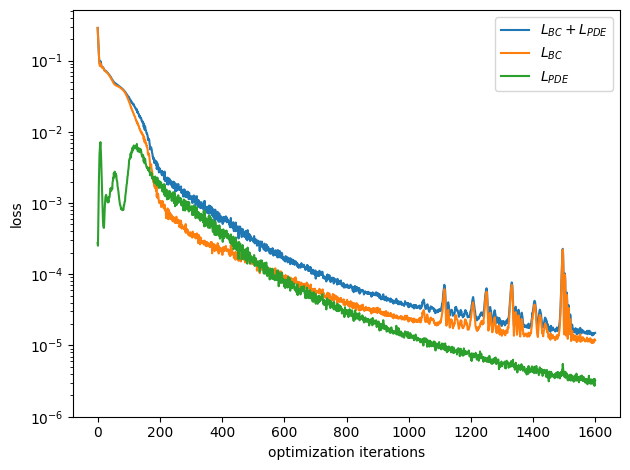

In [19]:
plt.semilogy(np.array(L_bc_evol) + np.array(L_pde_evol), label = r'$L_{BC}+L_{PDE}$')
plt.semilogy(L_bc_evol, label = r'$L_{BC}$')
plt.semilogy(L_pde_evol, label = r'$L_{PDE}$')
plt.ylabel('loss')
plt.xlabel('optimization iterations')
plt.ylim(1e-6,)
plt.legend()
plt.tight_layout()

The $L_{BC}$ and $L_{PDE}$ curves above show that the optimization was successful.
The $L_{BC}$ and $L_{PDE}$ both start high and progressively decrease as the optimization proceeds.
Note that the curves are not monotonically decreasing. This is because the $L_{PDE}$ error/residual is evaluated on randomly sampled points in the domain at each iteration. This means that $L_{PDE}$ can oscillate, since sometimes the randomly selected points are such that $L_{PDE}$ is low and other times it is higher. This stochasticity is generally good for the optimization of the PINN -- to find good minima.

Note also that this network could be further fine-tuned. The $L_{PDE}$ and $L_{BC}$ curves have not yet converged, so one could continue the optimization further. In addition, one could also use a larger number of collocation points (which will reduce the stochasticity in the $L_{PDE}$ curve) and using a lower learning rate. Nevertheless, this PINN solution is already a good approximation to the true solution.

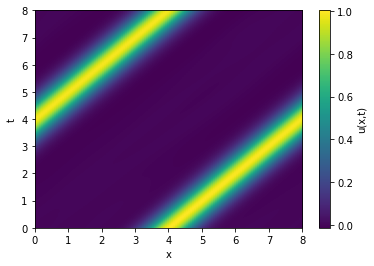

In [169]:
# Plotting the PINN solution of the linear advection PDE:

# vtn = 64
# vxn = 128
vtn, vxn = f_evol.shape
vx = np.linspace (0, bc_data.L, vxn )
vt = np.linspace (0, bc_data.T, vtn )
Vx, Vt = np.meshgrid(vx,vt)
Vx = torch.FloatTensor(Vx.flatten().reshape(-1,1))
Vt = torch.FloatTensor(Vt.flatten().reshape(-1,1))
u = pinn(Vx,Vt).reshape(vtn,vxn)
u = u.detach().numpy()

plt.imshow(u, origin = 'lower', extent = [0,bc_data.L,0,bc_data.T], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(label = 'u(x,t)')

We can compare our PINN solution with the FTCS finite difference solution obtained earlier:

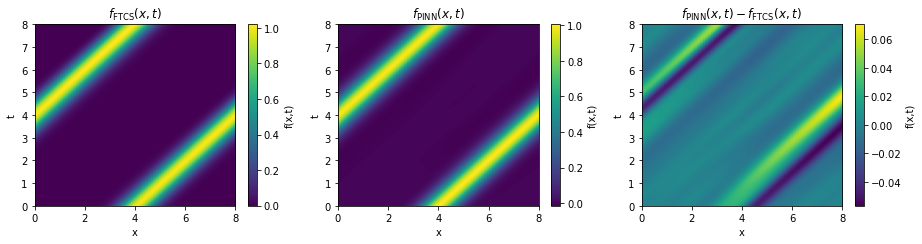

In [170]:
plt.figure(figsize=(13,3.5))
plt.subplot(1,3,1)
plt.title(r'$f_\mathrm{FTCS}(x,t)$')
plt.imshow(f_evol, origin = 'lower', extent = [0,bc_data.L,0,bc_data.T], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(label = 'f(x,t)')

plt.subplot(1,3,2)
plt.title(r'$f_\mathrm{PINN}(x,t)$')
plt.imshow(u, origin = 'lower', extent = [0,bc_data.L,0,bc_data.T], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(label = 'f(x,t)')

plt.subplot(1,3,3)
plt.title(r'$f_\mathrm{PINN}(x,t)-f_\mathrm{FTCS}(x,t)$')
plt.imshow(u-f_evol, origin = 'lower', extent = [0,bc_data.L,0,bc_data.T], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(label = 'f(x,t)')

plt.tight_layout()

We see above that while the qualitative structure of the PINN solution looks good, there are still some spurious structures in the solution (spurious striations in the solution) that are not physical. These are small errors (about $6\%$) relative to the typical values of the solution.

This could improve with further optimization and a better choice of neural network (or trial function) architecture.